In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
from dataclasses import dataclass

In [2]:
def trend(time , slope = 0): # trend is data's feature 
    return slope * time 

def seasonal_pattern(season_time): # generate pattern by season_time(numpy ndarray)
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time)) 

def seasonality(time, period, amplitude=1 , phase=0): # make a seasonal pattern using seasonal_pattern function.
    season_time = ((time + phase) % period) / period  # You define ndarray season_time 
    return amplitude * seasonal_pattern(season_time) 

def noise(time, noise_level=1, seed=None): # generate noise in order to make synthetic data
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level 

def plot_series(time, series, format="-", title="", label=None, start=0, end = None):
    plt.plot(time[start:end], series[start:end], format, label= label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("series")
    if label:
        plt.legend() # display a what kind of data is plotted (설명창 = 범례)
    plt.grid(True)

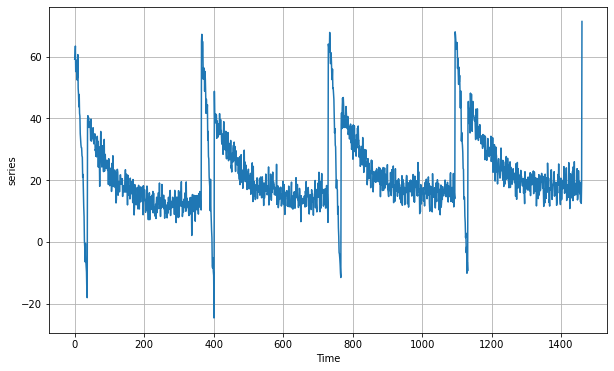

In [3]:
def generate_time_series():

    time = np.arange(4 * 365 + 1, dtype="float32")
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


@dataclass # @dataclass 데코레이터를 일반 클래스에 선언해줌
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer = G.SHUFFLE_BUFFER_SIZE):

    dataset = tf.data.Dataset.from_tensor_slices(series) # make one dataset 
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)

    dataset = dataset.map(lambda x: (x[:-1], x[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [6]:
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


In [7]:
## Trying to make a DNN to train 
def create_model(window_size=G.WINDOW_SIZE):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(1) # loss, optimizer
    ])
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
    )
    return model

In [9]:
dataset = windowed_dataset(series_train)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50,callbacks=[lr_schedule])

Epoch 1/50
34/34 [==============================] - 0s 2ms/step - loss: 202.4755 - lr: 1.0000e-05
Epoch 2/50
34/34 [==============================] - 0s 1ms/step - loss: 44.9225 - lr: 1.1220e-05
Epoch 3/50
34/34 [==============================] - 0s 1ms/step - loss: 40.1647 - lr: 1.2589e-05
Epoch 4/50
34/34 [==============================] - 0s 1ms/step - loss: 36.4701 - lr: 1.4125e-05
Epoch 5/50
34/34 [==============================] - 0s 2ms/step - loss: 34.1125 - lr: 1.5849e-05
Epoch 6/50
34/34 [==============================] - 0s 1ms/step - loss: 32.8952 - lr: 1.7783e-05
Epoch 7/50
34/34 [==============================] - 0s 1ms/step - loss: 31.9387 - lr: 1.9953e-05
Epoch 8/50
34/34 [==============================] - 0s 1ms/step - loss: 31.5671 - lr: 2.2387e-05
Epoch 9/50
34/34 [==============================] - 0s 1ms/step - loss: 29.4614 - lr: 2.5119e-05
Epoch 10/50
34/34 [==============================] - 0s 1ms/step - loss: 29.2812 - lr: 2.8184e-05
Epoch 11/50
34/34 [=========

In [ ]:
##conv + time series model 
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv1D(32, kernel_size=5, strides=1, padding='casual', activation='relu',input_shape=[None,1]),
                                        tf.keras.layers.LSTM(32, return_sequences=True),
                                        tf.keras.layers.LSTM(32),
                                        tf.keras.Dense(30, activation='relu'),
                                        tf.keras.Dense(30, activation='relu'),
                                        tf.keras.layers.Dense(1),
                                        tf.keras.layers.Lambda(lambda x: x* 400) # scale up since using tanh     
    ])
    return model